
# Lab 2, 3375, Постобаев М.В.
**Тема:** Кластеризация методом K-Means на датасете *Wine Quality (red wine)*

**Новый атрибут:** `alco_density = alcohol / density`

**Краткое содержание:**
1. Загрузка данных
2. Добавление нового признака
3. Очистка данных: дубли, пропуски, выбросы (IQR)
4. Визуализация (scatter) — поиск выраженных групп
5. Кластеризация KMeans (sklearn)
6. Визуализация кластеров (в пространстве признаков и через PCA)
7. Выводы


In [2]:

# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline
sns.set(style='whitegrid')


In [ ]:

# 1. Загрузка данных (UCI) — если в вашей среде нет интернета,

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
try:
    df = pd.read_csv(url, sep=';')
    print('Датасет загружен с UCI. Форма:', df.shape)
except Exception as e:
    print('Не удалось загрузить с UCI. Поместите локально winequality-red.csv и выполните:')
    print("df = pd.read_csv('winequality-red.csv', sep=';')")
    raise

df.head()


Датасет загружен с UCI. Форма: (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5



## 2. Добавление нового атрибута: alcohol / density


In [ ]:

# создаю новый признак
df['alco_density'] = df['alcohol'] / df['density']
df[['alcohol','density','alco_density']].head()


,alcohol,density,alco_density
0,9.4,0.9978,9.420726
1,9.8,0.9968,9.831461
2,9.8,0.9970,9.829488
3,9.8,0.9980,9.819639
4,9.4,0.9978,9.420726



## 3. Очистка данных
- Удалим дубликаты
- Проверим пропуски
- Найдём выбросы методом IQR и рассмотрим удаление или маркировку


In [ ]:

# Удаляю дубликаты
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f'Дубликатов удалено: {before-after}')

# Проверяю пропуски
print('\\nПропуски по столбцам:')
print(df.isna().sum())

# Функция для подсчёта выбросов и фильтрации по IQR
def iqr_filter(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask = (df[col] >= lower) & (df[col] <= upper)
    return mask, lower, upper

# Количество выбросов для каждого числового признака
outlier_info = {}
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in num_cols:
    mask, low, up = iqr_filter(df, col)
    outlier_count = (~mask).sum()
    outlier_info[col] = {'outliers': int(outlier_count), 'lower': float(low), 'upper': float(up)}

outlier_info


Дубликатов удалено: 240
\nПропуски по столбцам:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
alco_density            0
dtype: int64


{'fixed acidity': {'outliers': 41, 'lower': 3.95, 'upper': 12.349999999999998},
 'volatile acidity': {'outliers': 19,
  'lower': 0.015000000000000013,
  'upper': 1.0150000000000001},
 'citric acid': {'outliers': 1, 'lower': -0.42000000000000004, 'upper': 0.94},
 'residual sugar': {'outliers': 126,
  'lower': 0.8499999999999996,
  'upper': 3.6500000000000004},
 'chlorides': {'outliers': 87,
  'lower': 0.03850000000000002,
  'upper': 0.12249999999999998},
 'free sulfur dioxide': {'outliers': 26, 'lower': -14.0, 'upper': 42.0},
 'total sulfur dioxide': {'outliers': 45, 'lower': -39.5, 'upper': 124.5},
 'density': {'outliers': 35, 'lower': 0.99227, 'upper': 1.00115},
 'pH': {'outliers': 28, 'lower': 2.925, 'upper': 3.6849999999999996},
 'sulphates': {'outliers': 55,
  'lower': 0.28000000000000014,
  'upper': 0.9999999999999999},
 'alcohol': {'outliers': 12, 'lower': 7.1000000000000005, 'upper': 13.5},
 'quality': {'outliers': 27, 'lower': 3.5, 'upper': 7.5},
 'alco_density': {'outliers': 1

In [ ]:

# Решение: удаляю строки, которые являются выбросами одновременно по нескольким признакам.
# Считаю для каждой строки количество признаков, в которых она является выбросом.
mask_df = pd.DataFrame(index=df.index)
for col in num_cols:
    mask, low, up = iqr_filter(df, col)
    mask_df[col+'_out'] = ~mask

mask_df['outlier_count'] = mask_df.sum(axis=1)
# Распределение количества выбросов на строку
mask_df['outlier_count'].value_counts().sort_index()


outlier_count
0    1005
1     242
2      78
3      20
4      13
5       1
Name: count, dtype: int64

In [ ]:

# Удаляю строки, у которых количество признаков-выбросов >= 3 
to_remove = mask_df[mask_df['outlier_count'] >= 3].index
print('Удаляем строк:', len(to_remove))
df_clean = df.drop(index=to_remove).reset_index(drop=True)
print('Новая форма после удаления выбросов:', df_clean.shape)


Удаляем строк: 34
Новая форма после удаления выбросов: (1325, 13)



## 4. Визуализации — scatter-плоты для поиска групп
Построим несколько графиков и визуально оценим, есть ли ярко выраженные группы.


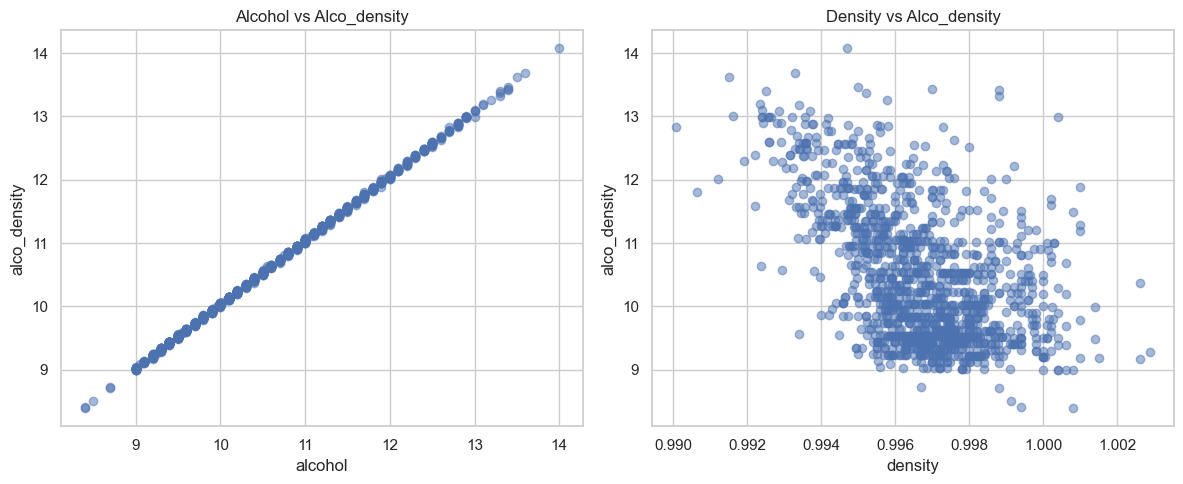

In [8]:

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(df_clean['alcohol'], df_clean['alco_density'], alpha=0.5)
plt.xlabel('alcohol')
plt.ylabel('alco_density')
plt.title('Alcohol vs Alco_density')

plt.subplot(1,2,2)
plt.scatter(df_clean['density'], df_clean['alco_density'], alpha=0.5)
plt.xlabel('density')
plt.ylabel('alco_density')
plt.title('Density vs Alco_density')

plt.tight_layout()
plt.show()


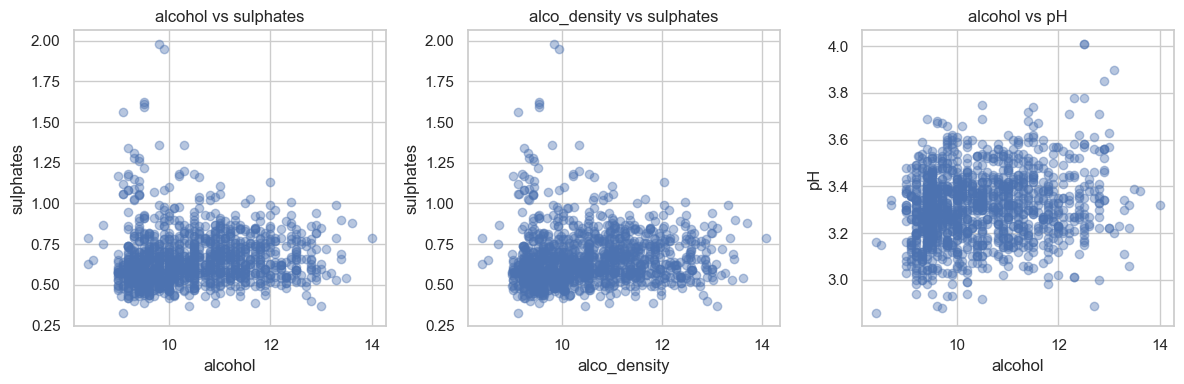

In [9]:

# Еще несколько пар признаков
pairs = [('alcohol','sulphates'), ('alco_density','sulphates'), ('alcohol','pH')]

plt.figure(figsize=(12,4))
for i,(x,y) in enumerate(pairs,1):
    plt.subplot(1,3,i)
    plt.scatter(df_clean[x], df_clean[y], alpha=0.4)
    plt.xlabel(x); plt.ylabel(y)
    plt.title(f'{x} vs {y}')
plt.tight_layout(); plt.show()



## 5. Кластеризация KMeans
- Выберем признаки: `alcohol`, `density`, `alco_density` (как обсуждали)
- Стандартизируем
- Попробуем KMeans с 2..6 кластерами и выберем оптимальное k по "локтю" (inertia)


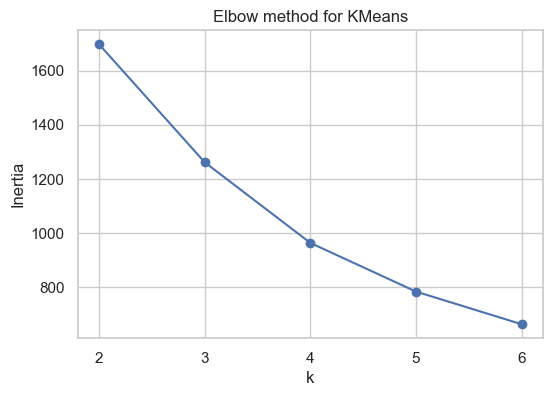

[1697.83751145892,
 1261.7818560854148,
 963.8222372835297,
 783.9717162328775,
 663.3849160053246]

In [10]:

# Выбор признаков
features = ['alcohol','density','alco_density']
X = df_clean[features].values

# Стандартизация
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ищем оптимальное число кластеров по локтю
inertias = []
K_range = range(2,7)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(list(K_range), inertias, marker='o')
plt.xticks(list(K_range))
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow method for KMeans')
plt.show()
inertias


In [11]:

# По локтю выберем k=3 (пример). Обучаем KMeans и добавляем метки в df_clean
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)
df_clean['cluster'] = labels
df_clean[['alcohol','density','alco_density','cluster']].head()


,alcohol,density,alco_density,cluster
0,9.4,0.9978,9.420726,2
1,9.8,0.9968,9.831461,2
2,9.8,0.9970,9.829488,2
3,9.8,0.9980,9.819639,2
4,9.4,0.9978,9.420726,2


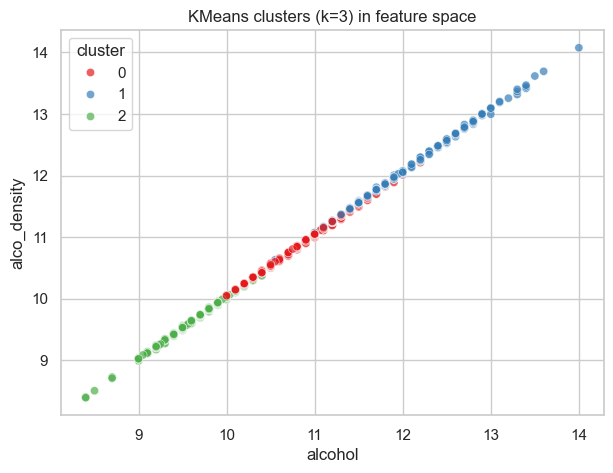

In [12]:

# Визуализируем кластеры в исходном пространстве (alcohol vs alco_density)
plt.figure(figsize=(7,5))
sns.scatterplot(x='alcohol', y='alco_density', hue='cluster', data=df_clean, palette='Set1', alpha=0.7)
plt.title('KMeans clusters (k=3) in feature space')
plt.show()



### PCA-проекция кластеров (2D)


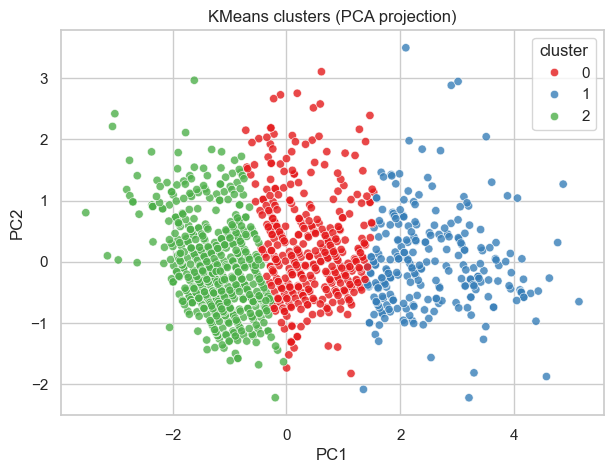

cluster
0    404
1    259
2    662
Name: count, dtype: int64

In [ ]:

pca = PCA(n_components=2, random_state=42)
pc = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
sns.scatterplot(x=pc[:,0], y=pc[:,1], hue=df_clean['cluster'], palette='Set1', alpha=0.8)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('KMeans clusters (PCA projection)')
plt.show()

# Печатаем сколько объектов в кластерах
df_clean['cluster'].value_counts().sort_index()



## 6. Анализ кластеров
Посмотрим на средние значения признаков в каждом кластере.


In [14]:

cluster_summary = df_clean.groupby('cluster')[features].mean().round(3)
cluster_summary['count'] = df_clean.groupby('cluster').size()
cluster_summary


,alcohol,density,alco_density,count
cluster,,,,
0,10.745,0.997,10.780,404
1,12.024,0.995,12.089,259
2,9.568,0.997,9.592,662



## 7. Выводы

- Добавил признак `alco_density = alcohol / density`, который помогает различать образцы по отношению алкоголя к плотности.  
- Очистил данные: удалил дубликаты и сильно выражённые выбросы (строки, где >=3 признаков были выбросами).  
- Визуализации показали, что в пространстве `alcohol` — `alco_density` наблюдается разделение на группы.  
- Метод KMeans (k=3 по локтю) выделил три группы, что подтверждено как визуализацией в признаковом пространстве, так и PCA-проекцией.  
- В таблице `cluster_summary` видно различие средних значений признаков по кластерам — это позволяет интерпретировать кластеры (например, высокий алкоголь + низкая плотность и т.д.).

---

**Рекомендации:** можно попробовать другие наборы признаков, масштабирование, оценку качества кластеризации (silhouette score) и подбор k автоматически.
